In [1]:
import numpy as np
import pandas as pd
import re,os
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

In [2]:
conditions = ['tumor_only','normal_only','hbv_only','nonhbv_only']
np_ratio = [25,15,20,20]
exp_m = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/LIHC_coding_gene_fpkm.txt',sep='\t',index_col=0)
hallmark= pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt",sep='\t')
hallmark_gene = hallmark['EnsID'].values

In [3]:
con = 'normal'
vote_path = "/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/%s_only_std_by_gene/" % con
vote_number = np.load(vote_path + "%s_only_std_by_gene__vote_np_ratio_15.npy" % con)
train_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/hbv_only_coding_gene_std_by_gene_with_synthetic.txt",index_col=0,sep='\t')
vote = pd.Series(vote_number,index=train_m.index)

In [4]:
from sklearn.decomposition import PCA

def hallmark_synthetic_pca(exp_profile,hallmark_list,vote_series,title,fig_output,scale=True) :
    #target gene
    syn_idx = [bool(re.search('Synthetic',x)) for x in vote.index]
    syn_id = list(vote.index[syn_idx])
    target_list = hallmark_list + syn_id 
    #standardize
    if scale :
        scaler = StandardScaler()
        std_m = scaler.fit_transform(exp_profile.loc[target_list,:].T.to_numpy())
        std_voted_exp = pd.DataFrame(std_m.T,index=target_list.index,columns=exp_profile.columns)
    else :
        std_voted_exp = exp_profile.loc[target_list,:]
    #PCA
    pca = PCA(n_components=2)
    vote_pca = pca.fit_transform(std_voted_exp)
    vote_df = pd.DataFrame(vote_pca,index=target_list,columns=['PC1','PC2'])
    vote_df['Vote'] = vote_series[target_list]
    vote_df['Label'] = ['Synthetic'] * vote_df.shape[0]
    vote_df.loc[hallmark_list,'Label'] = 'Hallmark'
    #plot
    plt.figure(figsize=(10,7))
    sns.scatterplot(data=vote_df,x='PC1',y='PC2',hue='Label',size='Vote')
    plt.title(title)
    #plt.savefig(fig_output,dpi=300)

In [ ]:
for idx,con in enumerate(conditions) :
    vote_path = "/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/%s_std_by_gene/" % con
    vote_number = np.load(vote_path + "%s_std_by_gene__vote_np_ratio_%d.npy" % (con,np_ratio[idx]))
    train_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/%s_coding_gene_std_by_gene_with_synthetic.txt" % con,index_col=0,sep='\t')
    vote = pd.Series(vote_number,index=train_m.index)
    title = "Hallmark & synthetic gene expression PCA (%s)" % con
    fig_path = '%s_hallmark_synthetic_vote_pca.png' % con
    hallmark_synthetic_pca(train_m,list(hallmark_gene),vote,title,fig_path,scale=False)

In [5]:
import matplotlib as mpl

def hallmark_gene_umap(vote_series,exp_matrix,hallmark_list,title,output_path,threshold=0) :
    #pre-processing
    voted_gene = vote_series.index[vote_series > threshold]
    voted_exp = exp_matrix.loc[voted_gene,:]
    scaler = StandardScaler()
    std_m = scaler.fit_transform(voted_exp.T.to_numpy())
    std_voted_exp = pd.DataFrame(std_m.T,index=voted_exp.index,columns=voted_exp.columns)
    #UMAP
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(std_voted_exp.to_numpy())
    metadata = pd.DataFrame({'Vote' : vote[voted_gene],'Label' : ['Voted_gene'] * len(voted_gene)},index=voted_gene)
    voted_hallmark_gene = list(set(hallmark_list).intersection(set(voted_gene)))
    metadata.loc[voted_hallmark_gene,'Label'] = 'Hallmark_gene'
    #visualize
    plot_df = pd.DataFrame({'UMAP1' : embedding[:,0],'UMAP2' : embedding[:,1],'Label' :metadata['Label'].values,'Vote' : metadata['Vote'].values}) # type: ignore
    plt.figure(figsize=(10,7))
    markers = {"Voted_gene": "o", "Hallmark_gene": "X"}
    hue_order = ["Hallmark_gene","Voted_gene"]
    sns.scatterplot(data=plot_df,x='UMAP1',y='UMAP2',hue='Vote',size='Vote',style='Label',size_norm=mpl.colors.PowerNorm(gamma=0.5),hue_order=hue_order,markers=markers) # type: ignore    
    plt.title(title)
    plt.savefig(output_path,dpi=300)
    return len(voted_hallmark_gene)

In [18]:
def hallmark_gene_umap_with_nonvoted(vote_series,exp_matrix,hallmark_list,title,output_path,threshold=0) :
    #pre-processing
    scaler = StandardScaler()
    std_m = scaler.fit_transform(exp_matrix.T.to_numpy())
    std_voted_exp = pd.DataFrame(std_m.T,index=exp_matrix.index,columns=exp_matrix.columns)
    #UMAP
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(std_voted_exp.to_numpy())
    metadata = pd.DataFrame({'Vote' : vote_series,'Label' : ['non_voted_gene'] * len(vote_series)},index=vote_series.index)
    voted_gene = vote_series.index[vote_series > threshold]
    voted_hallmark_gene = list(set(hallmark_list).intersection(set(voted_gene)))
    metadata.loc[voted_gene,'Label'] = 'Voted_gene'
    metadata.loc[voted_hallmark_gene,'Label'] = 'Hallmark_gene'
    #visualize
    plot_df = pd.DataFrame({'UMAP1' : embedding[:,0],'UMAP2' : embedding[:,1],'Label' :metadata['Label'].values,'Vote' : metadata['Vote'].values}) # type: ignore
    plt.figure(figsize=(10,7))
    markers = {"Voted_gene": "s","non_voted_gene" : "X","Hallmark_gene": "o"}
    ax = sns.scatterplot(data=plot_df[plot_df['Label'] == 'non_voted_gene'],x='UMAP1',y='UMAP2',hue='Vote',size='Vote',style='Label',markers=markers,alpha=0.3)# type: ignore 
    sns.scatterplot(data=plot_df[plot_df['Label'] != 'non_voted_gene'],x='UMAP1',y='UMAP2',hue='Vote',size='Vote',style='Label',markers=markers,alpha=0.7,ax=ax)
    plt.title(title)
    plt.savefig(output_path,dpi=300)
    return len(voted_hallmark_gene)

Number of hallmark gene were voted : 93
Number of hallmark gene were voted : 74
Number of hallmark gene were voted : 90
Number of hallmark gene were voted : 91


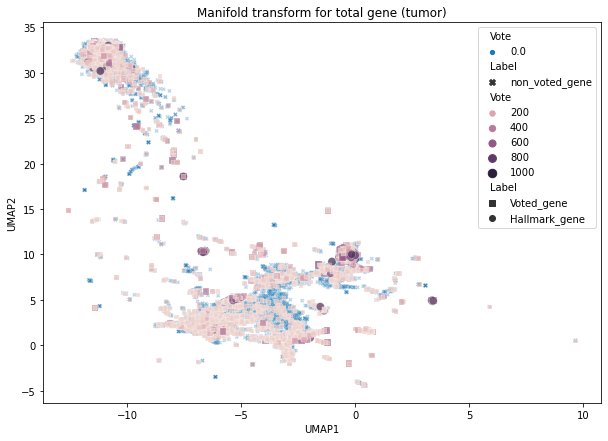

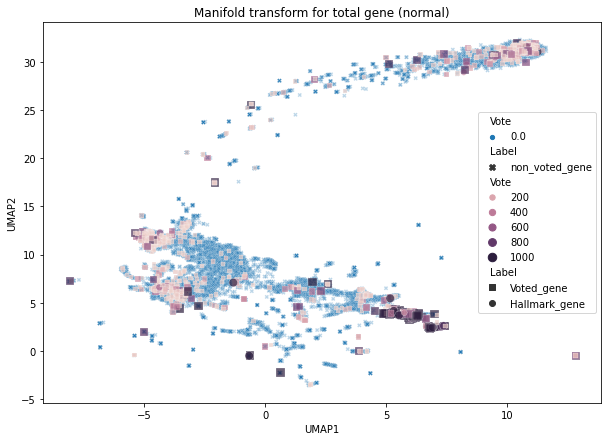

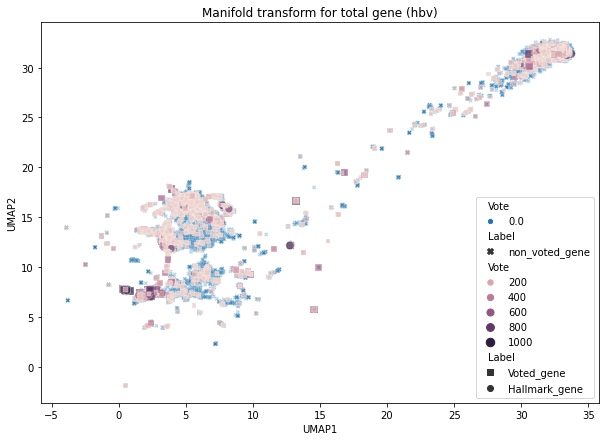

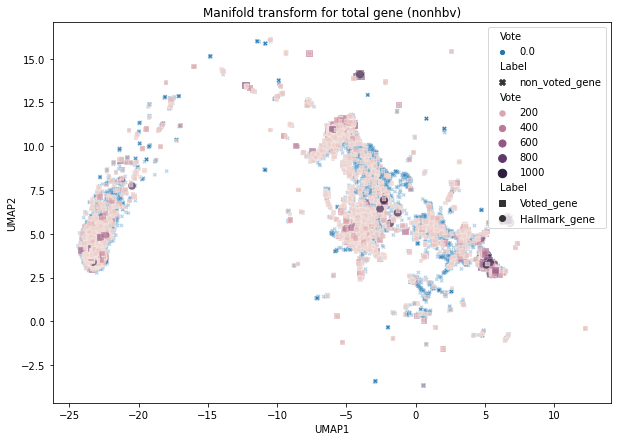

In [19]:
conditions = ['tumor','normal','hbv','nonhbv']
np_ratio = [25,15,20,20]
for idx,con in enumerate(conditions) :
    vote_path = "/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/%s_only_std_by_gene/" % con
    vote_number = np.load(vote_path + "%s_only_std_by_gene__vote_np_ratio_%d.npy" %(con,np_ratio[idx]))
    train_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/%s_only_coding_gene_std_by_gene_with_synthetic.txt" % con,index_col=0,sep='\t')
    vote = pd.Series(vote_number,index=train_m.index)
    title = 'Manifold transform for total gene (%s)' % con
    fig_output = '/home/bruce1996/data/LIHC_anomaly_detection/fig/voted_gene_manifold/%s_all_gene_umap.png' % con
    no_syn_idx = [bool(re.search('Synthetic',x)) == False for x in vote.index]
    vote_input = vote.loc[no_syn_idx]
    n_voted_hallmark = hallmark_gene_umap_with_nonvoted(vote_input,exp_m,hallmark_gene,title,fig_output)
    print("Number of hallmark gene were voted : %d" % n_voted_hallmark)